In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from import_utils import NotebookFinder
sys.meta_path.append(NotebookFinder())
from project_resources.cytochrome_P450 import *

importing Jupyter notebook from C:\Users\Lukas\Documents\Jupyter_Notebooks\project_resources\cytochrome_P450.ipynb


In [2]:
models = ["linear", "KRR", "GB", "RF", "ANN"]
isozymes = ["3A4", "RLM", "HLC"]
rel_paths = {
    "3A4_source": [r"project_resources/ChEMBL_3A4.csv", "ChEMBL"],
    "3A4": [r"project_resources/3A4_adjusted.csv", "ChEMBL"],

    "RLM_source": [r"project_resources/AID_1508591_datatable_all.csv", "PubChem"],
    "RLM": [r"project_resources/RLM_adjusted.csv", "ChEMBL"],

    "HLC_source": [r"project_resources/AID_1508603_datatable_all.csv", "PubChem"],
    "HLC": [r"project_resources/HLC_adjusted.csv", "ChEMBL"],
}
# files ending in "adjusted" only contain mol IDs, smiles and t1/2 values
smiles = {}
fingerprints = {}
fp_arrays = {}
xy_splits = {}
tanimoto_sims = {}
y_test_avg_predictions = {}
stds = {}
rmsds = {}
best_models = {}
# lists of repeatedly needed and\or similar info
# dicts for storing outputs and potentially writing them into a file

In [3]:
for isozyme in isozymes:
    if isozyme == "3A4":
        # load the downloaded file
        orig = abs_file_path(rel_paths["3A4_source"][0])
        df_source = pd.read_csv(orig, sep=";")
        # mols with Standard Type t1/2 have no Standard Value
        df_adjusted = df_source[df_source["Standard Type"] == "T1/2"]
        # filter it, so that all the molecules have a t1/2 value
        # and so that the file only includes useful info and rename certain columns
        df_adjusted = df_adjusted[["Molecule ChEMBL ID", "Smiles", "Standard Type", "Standard Value"]]
        df_adjusted = df_adjusted.rename(columns={"Molecule ChEMBL ID": "mol id", "Standard Value": "halflife", "Smiles": "smiles"})
        df_adjusted_abs_path = abs_file_path(rel_paths["3A4"][0])
        df_adjusted.to_csv(df_adjusted_abs_path, index=False)
    elif isozyme == "RLM":
        # load the downloaded file
        orig = abs_file_path(rel_paths["RLM_source"][0])
        df_source = pd.read_csv(orig)
        # replace >30 with 30
        # and only inclued useful info and rename certain columns
        df_adjusted = df_source[["PUBCHEM_CID", "Half-life (minutes)"]]
        df_adjusted = df_adjusted.rename(columns={"PUBCHEM_CID": "mol id", "Half-life (minutes)": "halflife"})
        df_adjusted = df_adjusted.replace({">30": '30'})
        df_adjusted_abs_path = abs_file_path(rel_paths["RLM"][0])
        df_adjusted.to_csv(df_adjusted_abs_path, index=False)
    elif isozyme == "HLC":
        orig = abs_file_path(rel_paths["HLC_source"][0])
        df_source = pd.read_csv(orig)
        # only include useful info and rename certain columns
        df_adjusted = df_source[["PUBCHEM_CID", "Half-life"]]
        df_adjusted = df_adjusted.rename(columns={"PUBCHEM_CID": "mol id", "Half-life": "halflife"})
        df_adjusted_abs_path = abs_file_path(rel_paths["HLC"][0])
        df_adjusted.to_csv(df_adjusted_abs_path, index=False)

In [4]:
# get smiles for mols in isozyme from mol id in their respective database
for isozyme in isozymes:
    src = abs_file_path(rel_paths[isozyme][0])
    df = pd.read_csv(src)
    list_mol_id = df["mol id"]
    list_smiles = smiles_from_mol_id(list_mol_id, rel_paths[isozyme][1], isozyme)
    smiles[isozyme] = list_smiles
    print(isozyme, len(list_smiles), list_smiles[:10])

3A4 70 ['CCC(=O)NCC[C@@H]1CCc2ccc3c(c21)CCO3', 'C[C@@H]1CN(CC(=O)N2CC(C)(C)c3ncc([C@@H](O)c4ccc(F)cc4)cc32)[C@@H](CN2[C@H](C)COC[C@H]2C)CN1', 'COc1cc(N)c(Cl)cc1C(=O)NC1CCN(CCCOc2ccc(F)cc2)CC1OC', 'COc1cc(N)c(Cl)cc1C(=O)NC1CCN(Cc2ccccc2)CC1', 'COc1ccc2[nH]cc(CCNC(C)=O)c2c1', 'C[C@@H]1CN(CC(=O)N2CC(C)(C)c3nnc(Cc4ccc(F)cc4F)cc32)[C@@H](CN2Cc3c(F)cccc3C2=O)CN1', 'O=c1[nH]c2ccccc2n1C1CCN(CCCC(c2ccc(F)cc2)c2ccc(F)cc2)CC1', 'C[C@@H]1CN(CC(=O)N2CC(C)(C)c3ncc(Cc4ccc(F)cc4)cc32)[C@@H](CN2Cc3ccccc3C2=O)CN1', 'C[C@@H]1CN(CC(=O)N2CC(C)(C)c3ncc(Cc4ccc(F)cc4)cc32)[C@@H](CN2[C@H](C)COC[C@H]2C)CN1', 'C[C@@H]1CN(CC(=O)N2CC(C)(C)c3nc(CO)c(Cc4ccc(F)cc4)cc32)[C@@H](CN2CCOC[C@H]2C)CN1']
RLM 2531 ['CCCCOC1=CC=C(C=C1)CC(=O)NO', 'COC1=C(C=C(C=C1)CCN2C(=CC(=O)NC2=S)N)OC', 'COC1=C(C=C(C=C1)Cl)C(=O)NC2=CC=C(C=C2)NC(=O)C3=CC=CO3', 'CC(C)(C)N1C2=NC=NC(=C2C(=N1)C3=CC=C(C=C3)Cl)N', 'CN1C2=CC=CC=C2C(=O)C3=C1N=C(N(C3=O)C4=CC=CC=C4)C5CCCCC5', 'CC1=C(C=C(C=C1)NS(=O)(=O)C2=CC=CC(=C2)C(=O)O)S(=O)(=O)N3CCOCC3', 'COC1=CC(=CC

In [5]:
# convert smiles from every isozyme to Morgan fingerprint as numpy array
for isozyme in isozymes:
    fps = fp_from_smiles(smiles[isozyme])
    fp_arrays[isozyme] = np.array(fps)
    print(fps[:1])

[array([1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])]
[array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])]
[array([0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 

In [6]:
# train-test split
for isozyme in isozymes:
    # Morgan fps as numpy arrays of smiles from given isozyme
    x = fp_arrays[isozyme]
    # halflife values corresponding to each of the fps
    y = np.log(np.array(pd.read_csv(abs_file_path(rel_paths[isozyme][0]))["halflife"]))

    idx_train, idx_test = train_test_split(np.arange(len(y)), test_size=0.2, random_state=42)

    x_train = x[idx_train]
    x_test = x[idx_test]

    y_train = y[idx_train]
    y_test = y[idx_test]

    fps_train = fp_arrays[isozyme][idx_train]
    fps_test = fp_arrays[isozyme][idx_test]

    xy_splits[isozyme] = [x_train, x_test, y_train, y_test]

    print(x.shape, y.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape, fps_train.shape, fps_test.shape)

(70, 124) (70,) (56, 124) (14, 124) (56,) (14,) (56, 124) (14, 124)
(2531, 124) (2531,) (2024, 124) (507, 124) (2024,) (507,) (2024, 124) (507, 124)
(189, 124) (189,) (151, 124) (38, 124) (151,) (38,) (151, 124) (38, 124)


In [7]:
for isozyme in isozymes:
    x_train = xy_splits[isozyme][0]
    x_test = xy_splits[isozyme][1]
    y_train = xy_splits[isozyme][2]
    y_test = xy_splits[isozyme][3]
    print(isozyme)
    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    y_test_avg_predict, std, rmsd = mol_predict_and_std(models, x_train, x_test, y_train, y_test)
    y_test_avg_predictions[isozyme] = y_test_avg_predict
    stds[isozyme] = std
    rmsds[isozyme] = rmsd
    print(f"     root-mean-square deviations: {rmsds[isozyme]}\n")

3A4
(56, 124) (56,) (14, 124) (14,)
     best linear hyperparams: ElasticNet(alpha=0.01)
     best linear hyperparams: ElasticNet(alpha=0.01, l1_ratio=1)
     best linear hyperparams: ElasticNet(alpha=0.01, l1_ratio=0)
     best KRR hyperparams: KernelRidge(alpha=0.00018329807108324357, gamma=4.281332398719387e-08,
            kernel='rbf')
     best KRR hyperparams: KernelRidge(alpha=2.9763514416313193, gamma=1.4384498882876659e-09,
            kernel='laplacian')
     best KRR hyperparams: KernelRidge(alpha=0.14384498882876628, gamma=3.792690190732238e-05,
            kernel='laplacian')
     best GB hyperparams: GradientBoostingRegressor(learning_rate=0.02, n_estimators=10)
     best GB hyperparams: GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=50)
     best GB hyperparams: GradientBoostingRegressor(learning_rate=0.02, n_estimators=20)
     best RF hyperparams: RandomForestRegressor(max_depth=3, max_features='log2', n_estimators=50)
     best RF hyperparams

In [8]:
for isozyme in isozymes:
    isozyme_rmsd = list(rmsds[isozyme].values())
    lowest_rmsd = min(isozyme_rmsd)
    best_model_for_isozyme = list(rmsds[isozyme].keys())[list(rmsds[isozyme].values()).index(lowest_rmsd)]
    best_models[isozyme] = best_model_for_isozyme
    print(f"best model for {isozyme}: {best_model_for_isozyme} with rmsd {lowest_rmsd}")

best model for 3A4: RF with rmsd 1.2991711361097664
best model for RLM: GB with rmsd 0.8965780310770572
best model for HLC: RF with rmsd 0.5373629035682629


In [9]:
for isozyme in isozymes:
    tanimoto_similarities = tanimoto(xy_splits[isozyme][1], xy_splits[isozyme][0])
    tanimoto_sims[isozyme] = tanimoto_similarities

[0.6808510638297872, 0.3684210526315789, 0.8142857142857143, 0.40625, 0.8703703703703703, 0.9649122807017544, 0.5, 0.9154929577464789, 0.810126582278481, 0.8771929824561403, 0.509090909090909, 0.9193548387096774, 0.9696969696969697, 0.9152542372881356] length: 14
[0.8085106382978723, 1.0, 0.7692307692307693, 0.6346153846153846, 0.8, 0.5172413793103449, 0.5245901639344263, 0.7540983606557377, 0.515625, 0.9736842105263158, 0.8163265306122449, 0.525, 0.8260869565217391, 0.8333333333333334, 0.9767441860465116, 0.5070422535211268, 0.5964912280701754, 0.813953488372093, 0.4666666666666667, 0.48148148148148145, 0.625, 0.4423076923076923, 0.86, 0.49056603773584906, 0.7272727272727273] length: 507
[0.8333333333333334, 0.8297872340425532, 0.46296296296296297, 0.7567567567567568, 0.8055555555555556, 0.5306122448979592, 0.725, 0.8666666666666667, 0.7419354838709677, 0.7391304347826086, 0.8048780487804879, 0.7948717948717948, 0.775, 0.8709677419354839, 0.8297872340425532, 0.8333333333333334, 0.6666

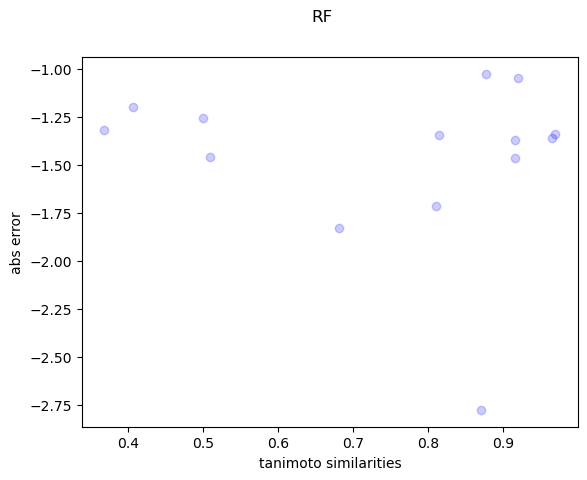

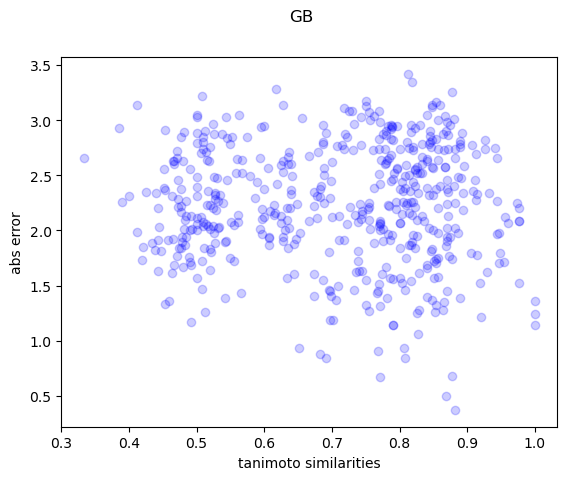

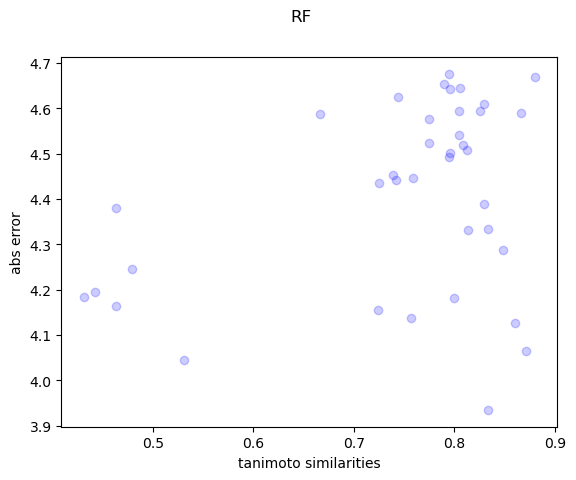

In [11]:
for isozyme in isozymes:
    model = best_models[isozyme]
    create_scatter_plot(tanimoto_sims[isozyme], y_test_avg_predictions[isozyme][model], model, "tanimoto similarities", "abs error")

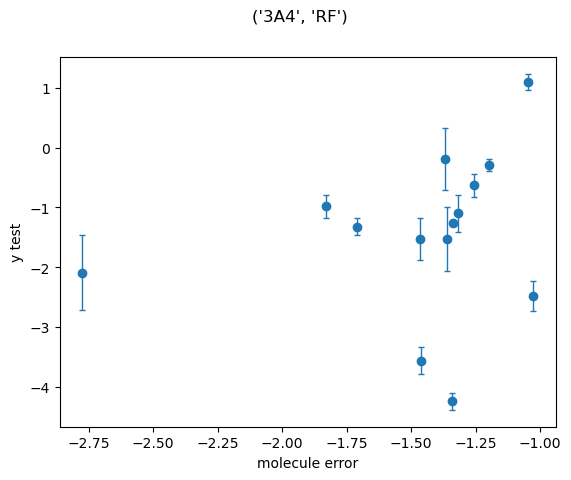

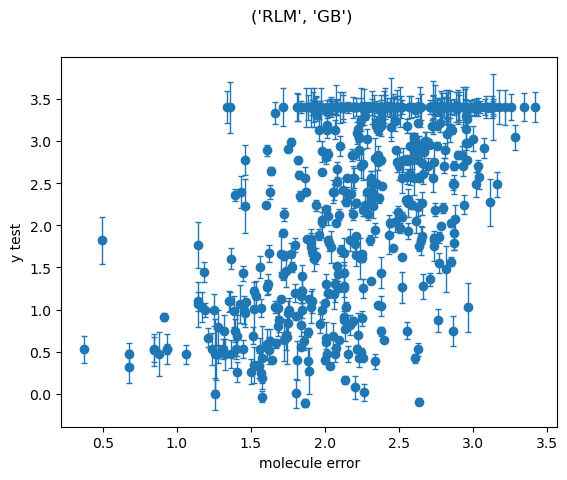

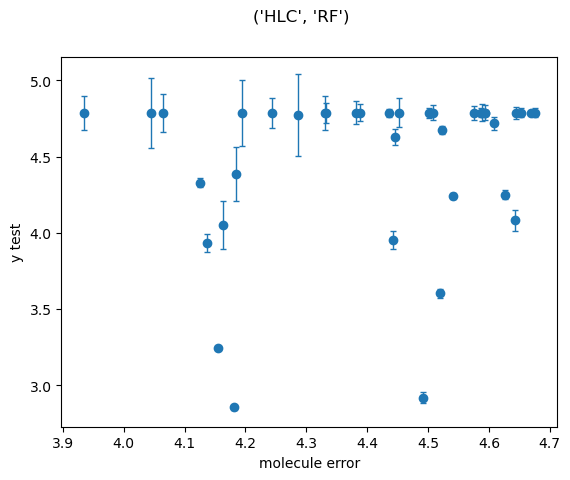

In [13]:
for isozyme in isozymes:
    model = best_models[isozyme]
    plt.clf()
    plt.errorbar(y_test_avg_predictions[isozyme][model], xy_splits[isozyme][3], yerr=stds[isozyme][model], linewidth=1, capsize=2, fmt='o')
    plt.xlabel('molecule error')
    plt.ylabel('y test')
    plt.suptitle(f"{isozyme, model}")
    plt.show()

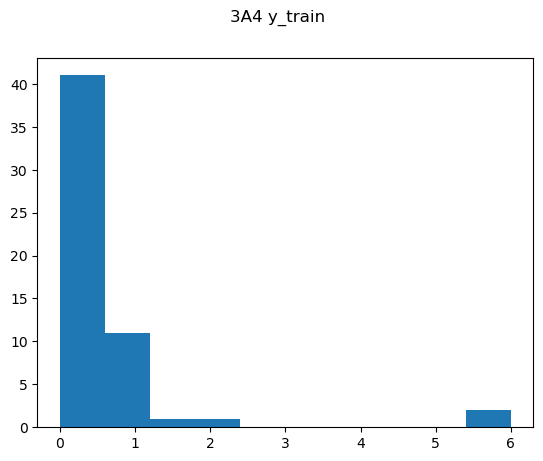

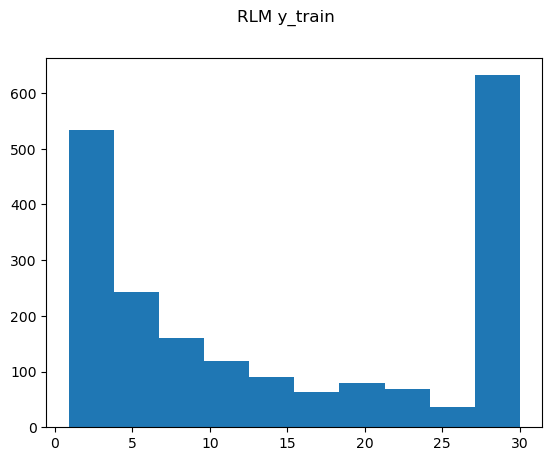

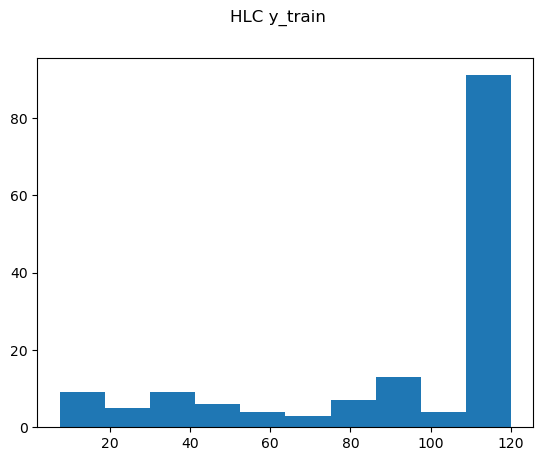

In [14]:
for isozyme in isozymes:
    y_train = np.exp(xy_splits[isozyme][2])
    plt.hist(y_train)
    plt.suptitle(f"{isozyme} y_train")
    plt.show()

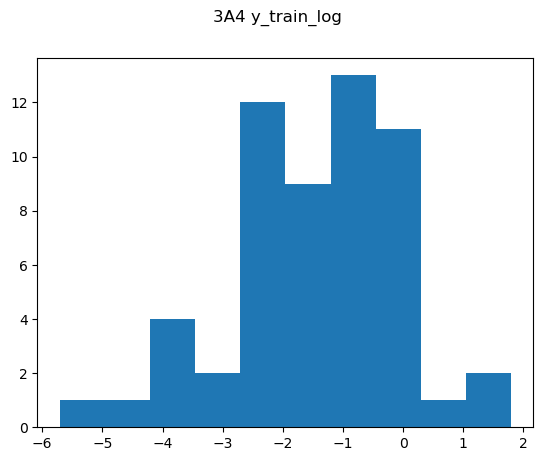

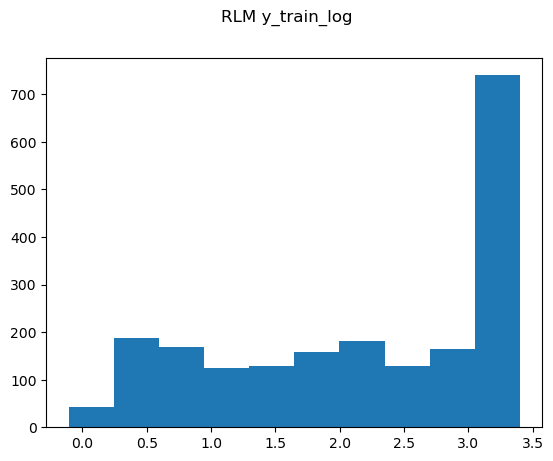

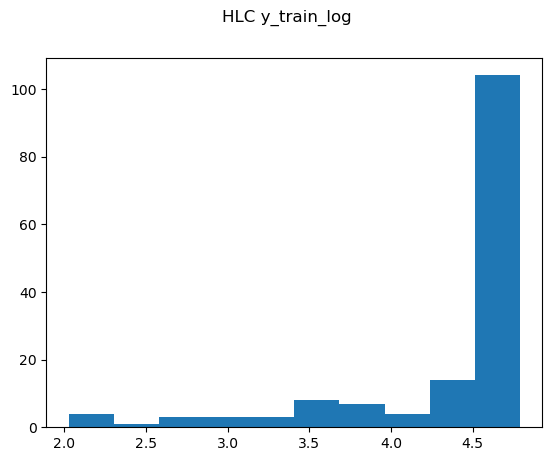

In [15]:
for isozyme in isozymes:
    y_train_log = xy_splits[isozyme][2]
    plt.hist(y_train_log)
    plt.suptitle(f"{isozyme} y_train_log")
    plt.show()